<a href="https://colab.research.google.com/github/PingPingE/Learn_ML_DL/blob/main/Practice/Hands_On_ML/ch13-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텐서플로에서 데이터 적재와 전처리하기

- 데이터의 양이 많은 경우, 이를 Binary로 serialization한 후 파일 형태로 저장하고 있다가, 이를 다시 읽어들이는 형태로 처리하면 속도 상의 이득을 기대할 수 있다.
- 이를 위해 protocol buffer형태로 serialization을 수행해서 저장할 수 있는 TFRecord 포맷이 필요한 것

*참고: [링크](http://solarisailab.com/archives/2603)<br>
*protocol buffer: 구글이 개발한 이식성과 확장성이 좋고 효율적인 이진 포맷

# TFRecord 포맷
- <strong>크기가 다른 연속된 이진 레코드</strong>를 저장하는 단순한 이진 포맷
- 각 레코드는 길이, 길이가 올바른지 체크하는 CRC 체크섬, 실제 데이터, 데이터를 위한 CRC 체크섬으로 구성
- <strong>tf.io.TFRecordWriter 클래스</strong>를 사용해서 TFRecord를 손쉽게 만든다.

In [ ]:
import tensorflow as tf
with tf.io.TFRecordWriter("my_data.tfrecord") as f: #TFRecord 만들기
  f.write(b"This is the first record")
  f.write(b"And this is the second record")

- tf.data.TFRecordDataset을 사용해서 하나 이상의 TFRecord를 읽을 수 있다.

In [ ]:
filepaths=['my_data.tfrecord']
dataset=tf.data.TFRecordDataset(filepaths) 
for item in dataset:
  print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


------------
기본적으로 TFRecordDataset은 파일을 하나씩 차례로 읽는다.
<br>-> num_parallel_reads를 지정해서 여러 파일에서 레코드를 번갈아 읽을 수 있다(DataAPI의 list_files()+interleave()와 동일한 결과)

## 압축된 TFRecord 파일
- 네트워크를 통해 읽어야 하는 경우, TFRecord파일을 압축할 필요가 있다.
- options 매개변수를 이용해서 압축된 TFRecord 파일을 만들 수 있다.

In [ ]:
options=tf.io.TFRecordOptions(compression_type="GZIP") #압축 형식 지정
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
  f.write(b"(compressed)This is the first record")
  f.write(b"(compressed)And this is the second record")

In [ ]:
filepaths=['my_compressed.tfrecord']
dataset=tf.data.TFRecordDataset(filepaths, compression_type="GZIP") #압축된걸 읽을 때도 compression_type을 지정해야 한다
for item in dataset:
  print(item)

tf.Tensor(b'(compressed)This is the first record', shape=(), dtype=string)
tf.Tensor(b'(compressed)And this is the second record', shape=(), dtype=string)


## 프로토콜 버퍼 개요
- 각 레코드는 어떤 이진 포맷도 사용할 수 있지만, 일반적으로 TFRecord는 직렬화된 프로토콜 버퍼를 담는다.


- 프로토콜 버퍼의 정의
```
syntax="proto3"#포맷 버전 3
#Person 객체 생성
message Person{
    string name=1;
    int32 id=2;
    repeated string email=3; #string 타입의 email필드를 하나 이상 가진다.
}
```

------
- 프로토콜 버퍼 객체는 직렬화해서 전송된 것을 의미하므로 message라고 부른다.
- 각 필드에 부여된 1,2,3 값은 필드 식별자로, 레코드의 이진 표현에 사용된다.

### 텐서플로 프로토콜 버퍼
- TFRecord 파일에서 사용하는 전형적인 주요 프로토콜 버퍼는 <strong>데이터셋에 있는 하나의 샘플을 표현하는 Example 프로토콜 버퍼다.</strong>



```
syntax="proto3"
message BytesList {repeated bytes value=1;}
message FloatList {repeated float value=1 [packed=True];}
message Int64List {repeated int64 value=1 [packed=True];}
message Feature{
    oneof kind{
        BytesList bytes_list=1;
        FloatList float_list=2;
        Int64List int64_list=3;
    }
};
message Features {map<string, Feature> feature=1; };
message Example {Features features=1; };
```



--------
- [packed=True]는 효율적인 인코딩을 위해 반복적인 수치 필드에 사용된다.
- Feature는 BytesList, FloatList, Int64List 중 하나를 담는다.
- Features는 특성이름과 특성값을 매핑한 딕셔너리
- Example은 하나의 Features 객체를 가진다.

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example=Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id":Feature(int64_list=Int64List(value=[123])),
            "emails":Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }
    )
)

In [ ]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
  f.write(person_example.SerializeToString()) #직렬화하고 결과 데이터를 tfrecord파일에 저장

-----------------------
보통은 현재 포맷(csv파일 같은)을 읽어 각 샘플마다 하나의 Example 프로토콜 버퍼를 생성하고, 위와 같이 저장한다.

### Example 프로토콜 버퍼를 읽고 파싱하기 

In [ ]:
#설명 딕셔너리
feature_description={
    "name":tf.io.FixedLenFeature([], tf.string,default_value=""),
    "id":tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails":tf.io.VarLenFeature(tf.string),  #repeated이므로 특성 리스트 길이가 가변적
}

In [ ]:
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
  parsed_example=tf.io.parse_single_example(serialized_example, feature_description) #parse_example()로 배치 단위로 파싱할 수도 있다.

In [ ]:
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
  parsed_example=tf.io.parse_single_example(serialized_example) #설명 딕셔너리 없으면 error

TypeError: ignored

- 가변 길이 특성은 희소 텐서로 파싱된다(고정 길이 특성은 보통의 텐서)

In [ ]:
tf.sparse.to_dense(parsed_example['emails'], default_value=b"") #희소 -> 밀집 변환

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [ ]:
parsed_example['emails'].values #근데 굳이 변환 할 필요 X 바로 참조하는 것이 더 간단

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

### SequenceExample 프로토콜 버퍼를 사용해서 리스트의 리스트 다루기

- SequenceExample 프로토콜 버퍼의 정의

```
message FeatureList { repeated Feature feature=1;};
message FeatureLists {map<string, FeatureList> feature_list =1;};
message SequenceExample{
  Features context=1;
  FeatureLists feature_lists=2;
};
```



------------
- 문맥 데이터를 위한 하나의 Features 객체와 이름이 있는 한 개 이상의 FeatureList를 가진 FeatureLists 객체를 포함한다.
- Feature 객체는 바이트 스트링, 64비트 정수, 실수의 리스트 중 하나
- 나머지 과정은 Example을 만들고 직렬화하고 파싱하는 것과 비슷

# 입력 특성 전처리
- 신경망을 위해 데이터를 준비하려면 일반적으로 모든 특성을 <strong>수치  특성</strong>으로 변환하고 <strong>정규화</strong>해야 한다.
- 방법: pandas, numpy, scikit learn, Data API, 전처리 층(Lambda 층 등)포함 등

## 전처리 담당 Lambda 층 포함하기

- 방법 1

In [ ]:
from tensorflow import keras
import numpy as np
X_train=tf.constant([1.,2.,3.])
means=np.mean(X_train, axis=0, keepdims=True)
stds=np.std(X_train, axis=0, keepdims=True)
eps=keras.backend.epsilon()

model=keras.models.Sequential([
                              keras.layers.Lambda(lambda inputs: (inputs-means)/(stds+eps)),
                              keras.layers.Dense(5),
                              keras.layers.Dense(1)
])

- 방법 2

In [ ]:
class Standardization(keras.layers.Layer):
  def adapt(self, data_sample):
    self.means_ = np.mean(data_sample, axis=0, keepdims=True)
    self.stds_ = np.std(data_sample, axis=0, keepdims=True)
  def call(self, inputs):
    return (inputs-self.means_)/(self.stds_+keras.backend.epsilon())

std_layer=Standardization()
std_layer.adapt(X_train)

------------
방법 1은 mean, std를 전역으로 선언해서 Lambda 층에 활용했고, <br>
방법 2는 사용자 정의 층을 만들어서 mean, std를 따로 계산하는 adapt 메서드를 만들었다. 

=> keras에는 "LayerNomalization"과 "BatchNormalization" 층이 구현되어 있다. 
[링크](https://keras.io/api/layers/normalization_layers/)

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcdaNCJ%2FbtqAa7RVwhD%2FP60H1iai2Mxgvu09TGQpv0%2Fimg.png" width=80% height=80%/>


출처: [링크](https://wingnim.tistory.com/92)

## 원-핫 벡터를 사용해서 범주형 특성 인코딩하기

In [ ]:
from sklearn.datasets import fetch_california_housing
california=fetch_california_housing()

In [ ]:
california.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

### 1. 룩업테이블로 각 범주를 인덱스(0~4)로 매핑

In [ ]:
vocab=['<1H OCEAN', 'INLAND','NEAR OCEAN', 'NEAR BAY', 'ISLAND'] #범주 리스트(어휘 사전) 생성
indices= tf.range(len(vocab), dtype=tf.int64) #위 범주에 해당하는 index 생성
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices) #범주 리스트와 인덱스를 전달하여 룩업 테이블 초기화 객체 생성(TextFileInitalizer도 있음 찾아보기)
num_oov_buckets=2 #oov: out of vocabulary => 룩업 테이블에 없는 범주를 찾으면 할당할 공간
table=tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets) #룩업테이블 만들기

--------------------
oov(out-of-vocabulary) 버킷을 사용하는 이유?

-> 범주 개수가 많고 데이터셋이 크거나 범주가 자주 바뀐다면 전체 범주 리스트를 구하는 것이 어려울 수 있다.

-> 그래서 oov 버킷을 충분히 확보해서 <strong>훈련 도중 발견되는 알려지지 않은 범주를 버킷에 할당</strong>하게 한다.

In [ ]:
categories= tf.constant(['NEAR BAY', 'DESERT', 'INLAND', 'INLAND'])
cat_indices=table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

------------
기존 룩업 테이블에 없던 DESERT는 새로운 인덱스(oov 버킷)인 5에 매핑되었다.

### 2. 인덱스 -> 원-핫 벡터로 변환

In [ ]:
cat_one_hot=tf.one_hot(cat_indices, depth=len(vocab)+num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

-----------------
어휘 사전 크기 + oov 버킷 수를 인자로 넘긴 tf.one_hot()함수를 사용해서 변환한다.

### TextVectorization
-  keras에는 <strong>TextVectorization</strong> 층이 구현되어 있다. 
- 해당 층에서 어휘 사전을 추출하고, 각 범주를 어휘 사전에 있는 인덱스로 변환한다.
- 이후 원-핫 벡터로 바꾸고 싶다면 이 층을 모델의 시작부분에 추가하고 뒤이어 tf.one_hot()함수가 적용된 Lambda 층을 놓으면 된다.

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.experimental.preprocessing.TextVectorization(input_shape=(1,)),
                                 keras.layers.Lambda(lambda x: tf.one_hot(x,depth=10)),#===== one-hot vector로 변환
                                 keras.layers.Dense(10)
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, None)              0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 10)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 10)          110       
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


## 임베딩을 사용해서 범주형 특성 인코딩하기 
- 임베딩은 범주를 표현하는 <strong>훈련 가능한 밀집 벡터</strong>이다.
  - ex) "NEAR BAY" => [0.131,0.890] 같은 벡터로 표현할 수 있다. 
- <strong>차원 수</strong>는 수정 가능한 하이퍼파라미터이다.
- <strong>비슷한 범주는 경사하강법이 더 가깝게</strong> 만들 것이다.
  - ex) 'NEAR BAY'와 'NEAR OCEAN'은 점점 가까워 질 것이고, 'INLAND'와는 점점 멀어질 것이다.
- 범주가 유용하게 표현되도록 임베딩이 훈련되는 경향이 있고, 이걸 <strong>표현 학습</strong>이라고 한다.

### 임베딩 행렬을 만들어 랜덤하게 초기화하기 

In [ ]:
embedding_dim =2 #튜닝해야함
embed_init = tf.random.uniform([len(vocab)+num_oov_buckets, embedding_dim]) #여기도 범주 개수와 oov 버킷 수를 넉넉하게 준다
embedding_matrix=tf.Variable(embed_init)

In [ ]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.7971518 , 0.39144683],
       [0.03259015, 0.94990695],
       [0.7508023 , 0.2669989 ],
       [0.0223366 , 0.3709513 ],
       [0.71096456, 0.73969376],
       [0.51081514, 0.8366407 ],
       [0.24649072, 0.64702   ]], dtype=float32)>

In [ ]:
categories= tf.constant(['NEAR BAY', 'DESERT', 'INLAND', 'INLAND'])
cat_indices=table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [ ]:
tmp_res=tf.nn.embedding_lookup(embedding_matrix, cat_indices)
tmp_res

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.0223366 , 0.3709513 ],
       [0.51081514, 0.8366407 ],
       [0.03259015, 0.94990695],
       [0.03259015, 0.94990695]], dtype=float32)>

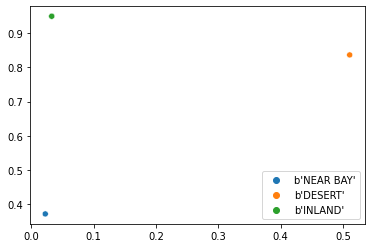

In [ ]:
import seaborn as sns
#찍어보자(훈련 전임)
sns.scatterplot(x=tmp_res[:,0], y=tmp_res[:,1],hue=categories)

### Keras의 Embedding층

- 기본적으로 학습가능한 임베딩 행렬을 처리해주는 keras의 Embedding 층이 있다.

In [ ]:
embedding=keras.layers.Embedding(input_dim=len(vocab)+num_oov_buckets, output_dim=embedding_dim)
tmp_res2=embedding(cat_indices)
tmp_res2

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.03490963, -0.00526176],
       [ 0.03720801,  0.0471353 ],
       [ 0.04819093,  0.0488869 ],
       [ 0.04819093,  0.0488869 ]], dtype=float32)>

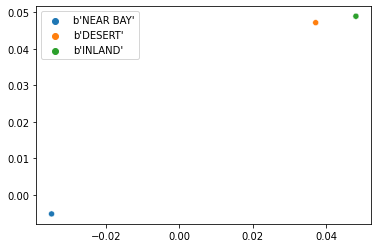

In [ ]:
#찍어보자(훈련 전임)
sns.scatterplot(x=tmp_res2[:,0], y=tmp_res2[:,1],hue=categories)

- 모두 연결해서 범주형 특성을 처리하고 각 범주마다 임베딩을 학습하는 모델 만들기

In [ ]:
regular_inputs=keras.layers.Input(shape=[8]) #샘플마다 8개의 특성을 담은 입력
categories=keras.layers.Input(shape=[], dtype=tf.string)

cat_indices=keras.layers.Lambda(lambda x: table.lookup(x))(categories) #범주의 인덱스를 찾는다
cat_embed=keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)

encoded_inputs=keras.layers.concatenate([regular_inputs, cat_embed]) #=== 신경망에 주입될 인코드된 입력
outputs=keras.layers.Dense(1)(encoded_inputs)
model=keras.models.Model(inputs=[regular_inputs, categories], outputs=[outputs])

-------------
- 원래 원-핫 인코딩 다음에 뒤따르는 Dense 층이 Embedding 층과 동일한 역할을 한다.
  - ex) 길이가 20인 원-핫 벡터와 10개의 유닛을 가진 Dense층 = input_dim=20, output_dim=10인 Embedding 층
- 그런데 Embedding 층이 더 적은 연산을 사용한다.(임베딩 행렬 크기가 커질 수록 더욱 차이가 커짐)


# TF 변환
- 전처리는 계산 비용이 크기 때문에 훈련과 동시에 수행하는 것보다 <strong>사전에 처리하면 속도를 크게 높일 수 있다.</strong>
- 즉, 데이터가 훈련하는 동안 epoch마다 전처리 되는 것이 아닌, <strong>훈련하기 전에 샘플마다 한 번씩만</strong> 전처리된다.
- 만약 RAM에 모든 데이터가 올라갈 수 있다면 cache()메서드, 아니면 Apache Beam이나 Spark 같은 도구가 도움이 된다. 

## 문제점: 훈련/서빙 왜곡
- 모델을 앱에 배포할 때, 모델에 주입될 데이터를 <strong>전처리하기 위해 앱마다 코드를 추가</strong>할 것이다.
- 그럼 전처리 과정을 바꿀 때마다 아파치 빔, 모바일 앱, 자바 스크립트 등의 코드를 수정해야하는가? -> 그럼 <strong>시간도 많이 걸리고, 에러를 만들기 쉬울 것이다.</strong>
- 이렇듯 훈련 전에 수행한 전처리 연산과 앱이나 브라우저에서 수행하는 전처리가 차이가 날 수있는데, 이걸 <strong>훈련/서빙 왜곡</strong>이라 한다.

### 해결 방법
- 훈련된 모델을 받아 배포하기 전에 <strong>전처리를 담당하는 층을 동적으로 추가</strong>하는 방법(즉 아파치 빔(or 스파크) 코드와 전처리 층의 코드로 구분)
- <strong>전처리 연산을 딱 한 번만</strong> 정의하려면? <strong>TF 변환</strong>

In [ ]:
#pip install tensorflow_transform

In [ ]:
import tensorflow_transform as tft
def preprocess(inputs): #이렇게 함수로 전처리 연산을 한 번만 정의
  median_age=inputs['housing_median_age']
  ocean_proximity=inputs['ocean_proximity']
  standardized_age=tft.scale_to_z_score(median_age)
  ocean_proximity_id=tft.compute_and_apply_vocabulary(ocean_proximity)
  return{
      "standardized_median_age":standardized_age,
      "ocean_proximity_id":ocean_proximity_id
  }


-------------
- TF 변환은 <strong>배포할 모델에 추가</strong>할 수 있도록 동일한 역할을 수행하는 <strong>텐서플로 함수</strong>를 생성한다는 것이 중요

# 텐서플로 데이터셋(TFDS) 프로젝트
- TFDS: 텐서플로우 데이터셋으로, 널리 사용되는 표준 데이터셋을 제공해준다.
- 이미지, 텍스트, 오디오,비디오 데이터셋이 포함 

In [ ]:
import tensorflow_datasets as tfds
dataset=tfds.load(name="mnist")
mnist_train, mnist_Test = dataset["train"], dataset["test"]

- 디폴트는 딕셔너리 형태

In [ ]:
mnist_train=mnist_train.shuffle(10000).batch(32).prefetch(1)
for item in mnist_train: #딕셔너리 형태로 나온다
  images=item['image']
  labels=item['label']

- 딕셔너리 -> 튜플

In [ ]:
#keras는 튜플을 기대하므로 바꾼다.
mnist_train=mnist_train.shuffle(10000).batch(32)
mnist_train=mnist_train.map(lambda items:(items['image'], items['label'])) #map 메서드 적용
mnist_train=mnist_train.prefetch(1)

- 더 간단하게 keras에 전달하는 방법

In [ ]:
dataset=tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train=dataset["train"].prefetch(1)
model=keras.models.Sequential([]) 

# 연습문제


1. 왜 데이터API를 사용하나요?

  - 데이터 API는 <strong>대용량 데이터셋을 읽고 효율적으로 전처리</strong>하기 위한 많은 기능을 제공한다. 
  - 다양한 소스에서 데이터를 적재하거나 / 동시에 여러 소스에서 데이터를 읽고 / 변환하고 / 레코드를 교대로 처리하고 / 섞고 / 배치와 프리패치 기능도 제공한다.



2. 대용량 데이터셋을 여러 파일로 나누면 어떤 장점이 있는지?

  - 셔플링 버퍼를 사용해서 데이터를 잘게 섞기 전에 <strong>크게 섞을 수 있다.</strong>
  - <strong>하나의 큰 파일보다 수천 개의 작은 파일을 다루는 것이 쉽다.</strong>



3. 훈련 과정에서 입력 파이프라인의 병목을 어떻게 찾는지? 병목현상을 고칠 순 있나요?

  - <strong>텐서보드</strong>를 사용해서 시각화 할 수 있다. 
  - GPU가 완전히 활용되지 않고 입력 파이프라인에 병목현상이 보인다면 <strong>여러 스레드에서 동시에 데이터를 읽고 전처리하여 몇 개의 배치를 프리패치</strong>해서 해결할 수 있다.
  - 만약 위 방법으로도 병목현상이 보인다면, 전처리 코드를 최적화 한다. (데이터 셋을 쪼개고 미리 전처리)

4. 어떤 이진 데이터도 TFRecord 파일 또는 직렬화된 프로토콜 버퍼로 저장할 수 있나요?
    
    - TFRecord파일은 <strong>임의의 이진 레코드의 시퀀스</strong>로 구성된다.
    - TFRecord 파일의 <strong>각 레코드에는 원하는 어떤 이진 데이터도 저장</strong>할 수 있다
    - 대부분 TFRecord파일은 <strong>직렬화된 프로토콜 버퍼의 시퀀스</strong>를 가지는데, 그 이유는 <strong>여러 프로토콜 버퍼의 장점</strong>을 사용할 수 있기 때문이다.
    - <strong>다양한 플랫폼과 언어</strong>에서 쉽게 읽을 수 있고 <strong>호환성</strong>을 유지하면서 프로토콜 정의를 업데이트할 수 있다.



5. 모든 데이터를 Example 프로토콜 버퍼 포맷으로 변환해야하나요? 자신만의 프로토콜 버퍼 정의를 사용하는 것은 어떤가요?

  - Example 프로토콜 포맷은 텐서플로가 몇 가지 파싱 연산(tf.io.parse*example()함수)을 제공하므로 굳이 자신만의 포맷을 정의할 필요가 없다.(가능하긴 함)
  - 또한, 이 포맷은 아주 유연하므로 대부분의 데이터셋에 있는 샘플을 표현할 수 있다.



6. TFRecord를 사용할 때 언제 압축을 사용하는지? 왜 기본적으로 압축을 사용하지 않나요?
  - 압축을 하는 이유: 훈련 스크립트로 TFRecord파일을 다운로드해야할 때, 파일 크기와 속도를 줄이기 위해
  - 근데 파일이 <strong>훈련 스크립트와 같은 머신</strong>에 있다면, 압축을 해제하기 위한 <strong>CPU 자원을 소모하지 않기 위해</strong> 압축 하지 않는다. 




7. 데이터 파일을 작성할 때, 또는 tf.data 파이프라인 안에서, 모델의 전처리 층에서, TF 변환을 사용해서 데이터를 전처리 할 수 있습니다. 각 방식의 장단점은?

  ■데이터 파일을 작성할 때
    
    [장점]
    - 실시간으로 전처리를 수행할 필요가 없어서 <strong>스크립트가 빨리 실행</strong>될 것이다.
    - 어떤 경우는 <strong>전처리된 데이터가 원본 데이터보다 크기가 작아서</strong> 다운 속도가 빠르고 공간을 절약할 수 있다.

   [단점]
      - <strong>전처리 로직마다 전처리된 데이터셋을 생성</strong>해야 함 -> 여러 로직을 실험하기 어렵다 
      - 데이터 증식을 수행하려면 <strong>데이터셋의 변종</strong>을 미리 만들어놔야 해서 <strong>디스크 공간</strong>이 많이 필요하고 <strong>생성 시간</strong>도 오래 걸린다.

      <br><br>
  
  ■tf.data 파이프라인

    [장점]
    - 전처리 로직을 <strong>변경</strong>하고 데이터 증식을 <strong>적용</strong>하기 쉽다.
    - 멀티스레딩, 프리페칭 등 더 <strong>효율적인</strong> 전처리 파이프라인을 만들 수 있다.

  [단점]
      - <strong>훈련 속도</strong>가 느려진다.
      - 데이터 파일을 만들 때 딱 한 번만 데이터를 전처리하는 것이 아닌, <strong>에포크마다 전처리</strong> 한다. 

      <br><br>

  ■모델의 전처리 층

     [장점]
    - 훈련과 추론을 위해 <strong>딱 한 번만 전처리 코드를 작성</strong>하면 된다.(여러 플랫폼에 배포해야 할 때 큰 장점)
    - 모델의 일부분이라서 <strong>잘못된 로직을 사용할 위험이 없다.</strong>

  [단점]
      - 훈련 속도가 느려진다.
      - 에포크마다 전처리
      - 각 배치의 전처리 연산이 GPU에서 실행된다. -> 즉, CPU의 멀티스레딩 및 프리페칭을 사용할 수 없다 (근데 케라스 전처리 층은 전처리 연산을 층에서 떼어내 tf.data 파이프라인의 일부로 실행할 수 있어서 멀티스레딩 및 프리페칭의 이점을 얻을 수 있을 것이라고 한다.)

      <br><br>
      
  ■TF변환
    
    [장점]
    - 데이터를 실제로 만들기 때문에 각 샘플이 딱 한 번만 전처리된다.(훈련 속도가 높아진다
    - 전처리 층이 자동으로 생성되어서 코드를 한 번만 작성하면 된다.

  [단점]
      - 사용법을 익혀야한다.


8. 범주형 특성을 인코딩할 수 있는 대표적인 방법을 나열해보세요. 텍스트 데이터는 어떻게 인코딩할 수 있나요?

  - '나쁨'/'보통'/'좋음'과 같이 <strong>순서가 있는 범주형</strong> 특성은 순서가 있는 인코딩을 사용한다. -> '나쁨':0, '보통':1, '좋음':2
  - 하지만 대부분의 범주형 특성은 내제된 순서가 없다. ex) 나라, 직업 등 -> <strong>원-핫 인코딩 or 임베딩(범주가 많은 경우)</strong>
  - 텍스트는 <strong>BoW표현</strong>을 사용하는 방법이 있다. 
    - BoW: Bag of Words
      - 전체 문서 집합의 단어들의 <strong>단어집</strong>을 만든 후, 특정 문서에서 단어집에 포함된 <strong>단어가 얼마나 자주 사용되었는지 횟수</strong>를 포함하는 각 문서에 대한 <storng>피처 벡터</strong>를 만든다. [참고](https://nlp.gitbook.io/book/nlp_basic/count-vector)
    - <strong>사전 훈련된 단어 임베딩</strong>을 사용해서 각 단어를 인코딩할 수 있다.
    - 단어를 인코딩하는 대신 <strong>각 글자를 인코딩하거나 부분 토큰을 인코딩</strong>할 수도 있다.